In [27]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import spaces

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.shares_held = 0
        self.current_step = 0
        self.done = False

        # 觀察空間包含 [Open, High, Low, Close, Volume, balance, shares_held]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)
        # 行動空間：0 = 持有, 1 = 買入, 2 = 賣出
        self.action_space = spaces.Discrete(3)

    def _next_observation(self):
        obs = np.array([
            float(self.data.iloc[self.current_step]['Open']),
            float(self.data.iloc[self.current_step]['High']),
            float(self.data.iloc[self.current_step]['Low']),
            float(self.data.iloc[self.current_step]['Close']),
            float(self.data.iloc[self.current_step]['Volume']),
            float(self.balance),
            float(self.shares_held)
        ], dtype=np.float32)
        return obs

    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 0
        self.done = False
        return self._next_observation()

    def step(self, action):
        current_price = float(self.data.iloc[self.current_step]['Close'])
        if action == 1:  # 買入
            if self.balance >= current_price:
                self.balance -= current_price
                self.shares_held += 1
        elif action == 2:  # 賣出
            if self.shares_held > 0:
                self.balance += current_price
                self.shares_held -= 1

        net_worth = self.balance + self.shares_held * current_price
        reward = net_worth - self.initial_balance

        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True

        next_state = self._next_observation() if not self.done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return next_state, reward, self.done, {}

In [31]:
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size    # 觀察空間維度
        self.action_size = action_size  # 行動空間維度
        self.memory = []              # 經驗回放記憶庫
        self.gamma = 0.99             # 折扣因子
        self.epsilon = 1.0            # 初始探索率
        self.epsilon_min = 0.01       # 最小探索率
        self.epsilon_decay = 0.995    # 探索率衰減率
        self.model = DQN(state_size, action_size).to(device)         # 當前 Q 網路移至 GPU
        self.target_model = DQN(state_size, action_size).to(device)    # 目標 Q 網路移至 GPU
        self.update_target_model()  # 初始化目標網路
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)  # 優化器
        self.criterion = nn.MSELoss()  # 損失函數

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        act_values = self.model(state)
        return torch.argmax(act_values, dim=1).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
                target = reward + self.gamma * torch.max(self.target_model(next_state_tensor)).item()
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            target_f = self.model(state_tensor).clone().detach()
            target_f[0][action] = target

            self.optimizer.zero_grad()
            output = self.model(state_tensor)
            loss = self.criterion(output, target_f)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)

In [22]:
import yfinance as yf

data = yf.download('AAPL', start='2020-01-01', end='2025-03-19', auto_adjust=False)
data.reset_index(inplace=True)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [32]:
env = StockTradingEnv(data)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)

n_episodes = 50
batch_size = 32
total_reward_list = []

for e in range(n_episodes):
    state = env.reset()
    total_reward = 0
    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay(batch_size)
        if done:
            agent.update_target_model()
            print(f"Episode: {e+1}/{n_episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
            total_reward_list.append(total_reward)
            break

/tmp/ipykernel_7441/2869792541.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Open']),
/tmp/ipykernel_7441/2869792541.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['High']),
/tmp/ipykernel_7441/2869792541.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Low']),
/tmp/ipykernel_7441/2869792541.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Close']),
/tmp/ipykernel_7441/2869792541.py:22: FutureWarning: Calling float o

Episode: 1/50, Total Reward: 98202.31, Epsilon: 0.01
Episode: 2/50, Total Reward: 96801.26, Epsilon: 0.01
Episode: 3/50, Total Reward: 106154.65, Epsilon: 0.01
Episode: 4/50, Total Reward: 183481.73, Epsilon: 0.01
Episode: 5/50, Total Reward: 1338429.13, Epsilon: 0.01
Episode: 6/50, Total Reward: 986431.78, Epsilon: 0.01
Episode: 7/50, Total Reward: 367310.56, Epsilon: 0.01
Episode: 8/50, Total Reward: 4941908.43, Epsilon: 0.01
Episode: 9/50, Total Reward: 3566437.44, Epsilon: 0.01
Episode: 10/50, Total Reward: 2112698.59, Epsilon: 0.01
Episode: 11/50, Total Reward: -512017.12, Epsilon: 0.01
Episode: 12/50, Total Reward: 9259737.56, Epsilon: 0.01
Episode: 13/50, Total Reward: 2685086.80, Epsilon: 0.01
Episode: 14/50, Total Reward: 3318558.94, Epsilon: 0.01
Episode: 15/50, Total Reward: 1218674.45, Epsilon: 0.01
Episode: 16/50, Total Reward: 8504507.04, Epsilon: 0.01
Episode: 17/50, Total Reward: 1513436.12, Epsilon: 0.01
Episode: 18/50, Total Reward: 3167712.75, Epsilon: 0.01
Episode: 

In [36]:
state = env.reset()
total_reward = 0
net_worths = []
for time in range(len(data) - 1):
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    total_reward += reward
    # 重新計算 net worth
    current_price = float(data.iloc[env.current_step - 1]['Close'])
    current_net_worth = env.balance + env.shares_held * current_price
    net_worths.append(current_net_worth)
    if done:
        print(f"Total Test Reward: {total_reward:.2f}")
        break


/tmp/ipykernel_7441/2869792541.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Open']),
/tmp/ipykernel_7441/2869792541.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['High']),
/tmp/ipykernel_7441/2869792541.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Low']),
/tmp/ipykernel_7441/2869792541.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Close']),
/tmp/ipykernel_7441/2869792541.py:22: FutureWarning: Calling float o

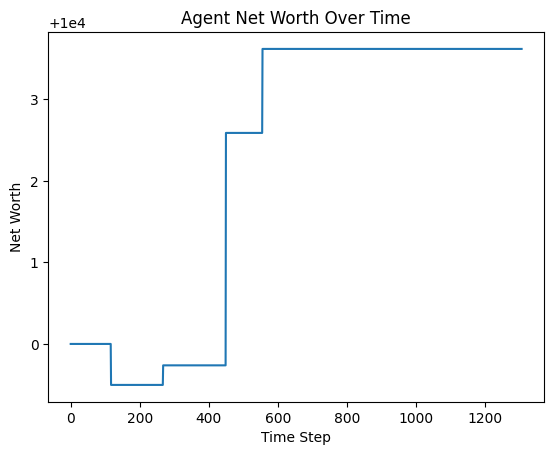

In [37]:
plt.plot(net_worths)
plt.xlabel('Time Step')
plt.ylabel('Net Worth')
plt.title('Agent Net Worth Over Time')
plt.show()